In [1]:
!pip install transformers
!pip install torch torchvision


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

## Image Segmentaion

`label_ids_to_fuse` unset. No instance will be fused.


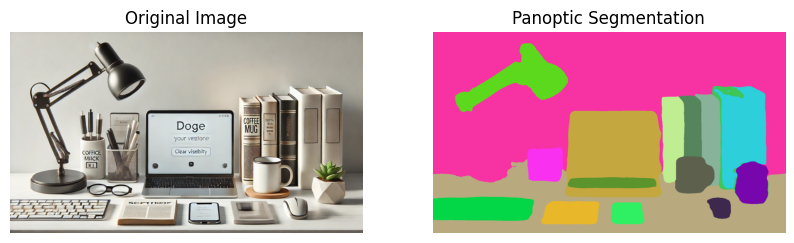

In [7]:
from PIL import Image
import torch
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
import matplotlib.pyplot as plt
import numpy as np

# Load an image
image = Image.open("/content/desk.png")

# Load the processor and model
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")

# Preprocess the image
inputs = processor(images=image, return_tensors="pt")

# Forward pass through the model
outputs = model(**inputs)

# Post-process the outputs to get the panoptic segmentation results
panoptic_seg = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

# Get the segmentation map and segment info
segmentation_map = panoptic_seg['segmentation']
segments_info = panoptic_seg['segments_info']

# Convert segmentation map to a color image
unique_labels = np.unique(segmentation_map)
colored_segmentation = np.zeros((*segmentation_map.shape, 3), dtype=np.uint8)

for label in unique_labels:
    mask = segmentation_map == label
    color = np.random.randint(0, 255, size=3)
    colored_segmentation[mask] = color

# Display the original image and the segmentation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(colored_segmentation)
plt.axis('off')
plt.title("Panoptic Segmentation")

plt.show()

# Print segment info
for segment in segments_info:
    print(f"Label: {segment['label_id']}, Confidence: {segment['score']}")


In [8]:

# Post-process the outputs to get segmentation info
result = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

# Extract the segments information
segments_info = result['segments_info']

# Manually create the id2label mapping
id2label = {int(k): v for k, v in model.config.id2label.items()}

# Check what keys are available in each segment and display them
for segment in segments_info:
    print("Available keys in segment:", segment.keys())  # Display the available keys in each segment
    segment_id = segment.get('id', 'N/A')
    category_id = segment.get('label_id', 'N/A')  # Try 'label_id' instead of 'category_id'
    label = id2label.get(category_id, 'Unknown')
    score = segment.get('score', 'N/A')  # Sometimes the score might not be available

    print(f"Segment ID: {segment_id}, Object: {label}, Score: {score}")


Label: 73, Confidence: 0.825055
Label: 131, Confidence: 0.994806
Label: 63, Confidence: 0.546004
Label: 73, Confidence: 0.918663
Label: 41, Confidence: 0.981547
Label: 67, Confidence: 0.986175
Label: 92, Confidence: 0.966479
Label: 73, Confidence: 0.958101
Label: 121, Confidence: 0.991891
Label: 66, Confidence: 0.882025
Label: 73, Confidence: 0.94078
Label: 58, Confidence: 0.978786
Label: 64, Confidence: 0.990911
Label: 41, Confidence: 0.652817
Label: 73, Confidence: 0.952177
Label: 66, Confidence: 0.993795


`label_ids_to_fuse` unset. No instance will be fused.


Available keys in segment: dict_keys(['id', 'label_id', 'was_fused', 'score'])
Segment ID: 1, Object: book, Score: 0.825055
Available keys in segment: dict_keys(['id', 'label_id', 'was_fused', 'score'])
Segment ID: 2, Object: wall-other-merged, Score: 0.994806
Available keys in segment: dict_keys(['id', 'label_id', 'was_fused', 'score'])
Segment ID: 3, Object: laptop, Score: 0.546004
Available keys in segment: dict_keys(['id', 'label_id', 'was_fused', 'score'])
Segment ID: 4, Object: book, Score: 0.918663
Available keys in segment: dict_keys(['id', 'label_id', 'was_fused', 'score'])
Segment ID: 5, Object: cup, Score: 0.981547
Available keys in segment: dict_keys(['id', 'label_id', 'was_fused', 'score'])
Segment ID: 6, Object: cell phone, Score: 0.986175
Available keys in segment: dict_keys(['id', 'label_id', 'was_fused', 'score'])
Segment ID: 7, Object: light, Score: 0.966479
Available keys in segment: dict_keys(['id', 'label_id', 'was_fused', 'score'])
Segment ID: 8, Object: book, Sco

## Object Extraction and Storage

In [10]:
import os
import cv2
import numpy as np
import sqlite3
from PIL import Image


In [11]:
# Directory to save extracted objects
output_dir = 'extracted_objects'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [12]:
# Database connection to store metadata
conn = sqlite3.connect('object_metadata.db')
cursor = conn.cursor()
cursor.execute('''
    CREATE TABLE IF NOT EXISTS objects (
        id INTEGER PRIMARY KEY,
        master_id TEXT,
        object_id TEXT,
        object_path TEXT
    )
''')

In [13]:
# Master ID for the original image
master_id = "desk_image"

In [14]:
# Convert the segmentation map to a NumPy array
segmentation_map = result["segmentation"].cpu().numpy()

In [15]:
# Initialize object ID counter
object_counter = 1

# Extract and save each object
for segment in segments_info:
    label_id = segment["label_id"]
    label = id2label[label_id]

    # Create a mask for the current object
    mask = (segmentation_map == segment["id"]).astype("uint8")

    # Find the bounding box of the segment
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        x, y, w, h = cv2.boundingRect(contours[0])

        # Extract the object using the bounding box
        extracted_object = np.array(image)[y:y+h, x:x+w]

        # Convert the extracted object to an image
        extracted_object_img = Image.fromarray(extracted_object)

        # Save the object with a unique ID
        object_id = f"object_{object_counter}"
        object_path = os.path.join(output_dir, f"{object_id}.png")
        extracted_object_img.save(object_path)

        # Store metadata in the database
        cursor.execute('''
            INSERT INTO objects (master_id, object_id, object_path)
            VALUES (?, ?, ?)
        ''', (master_id, object_id, object_path))

        # Increment the object counter
        object_counter += 1

# Commit and close the database connection
conn.commit()
conn.close()

print(f"Object extraction and storage completed. {object_counter - 1} objects were saved.")

Object extraction and storage completed. 16 objects were saved.


In [17]:
extracted_images = sorted(os.listdir(output_dir))


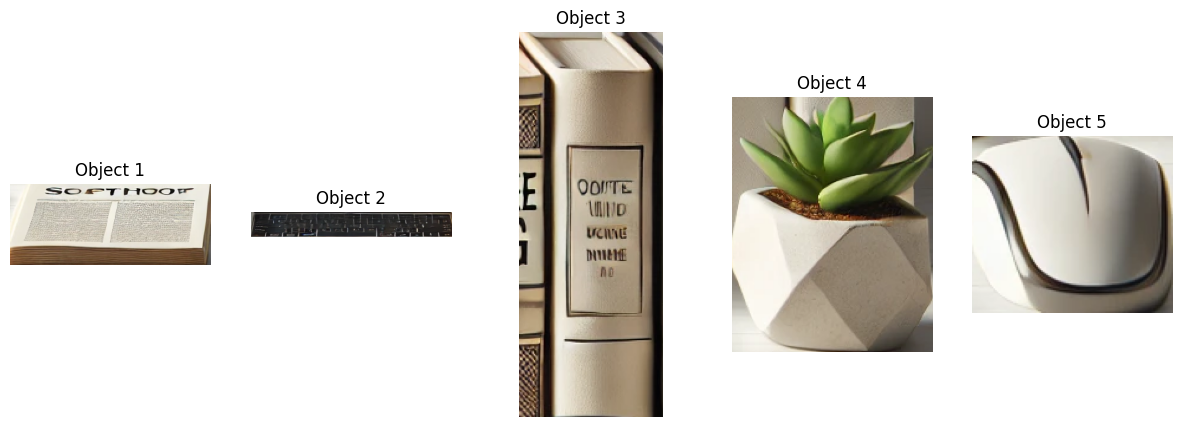

In [18]:
# Display the first few extracted images
num_images_to_show = min(5, len(extracted_images))
plt.figure(figsize=(15, 5))
for i in range(num_images_to_show):
    img_path = os.path.join(output_dir, extracted_images[i])
    img = Image.open(img_path)
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(img)
    plt.title(f"Object {i+1}")
    plt.axis('off')
plt.show()

## Object Identification

In [20]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image

# Load the model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")


In [21]:
import os
import pandas as pd

# Directory where extracted objects are stored
extracted_objects_dir = 'extracted_objects'

# Prepare to store generated descriptions
object_descriptions = []

# Generate descriptions using the image captioning model
for object_image in os.listdir(extracted_objects_dir):
    if object_image.endswith('.png'):
        # Load the image
        image_path = os.path.join(extracted_objects_dir, object_image)
        image = Image.open(image_path)

        # Prepare inputs for the model
        inputs = processor(image, return_tensors="pt")

        # Generate the caption
        out = model.generate(**inputs)
        caption = processor.decode(out[0], skip_special_tokens=True)

        # Store the result
        object_descriptions.append({
            "Object Image": object_image,
            "Description": caption
        })

# Convert to DataFrame for easy viewing
description_df = pd.DataFrame(object_descriptions)

# Display the DataFrame
print(description_df)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


     Object Image                                        Description
0   object_10.png                a black and white photo of a laptop
1   object_13.png                    a white chair with a black seat
2   object_11.png               a book with a picture of a man on it
3    object_2.png   a man in a suit and tie is looking at the camera
4    object_6.png     a silver and black electronic clock on a table
5   object_12.png             a small planter with a small sue in it
6    object_8.png  a white coffee mug sitting on top of a wooden ...
7    object_4.png    a white background with a light gray background
8   object_15.png                  a coffee cup and a mug on a table
9    object_9.png       a desk with a laptop, phone, and other items
10  object_14.png    a white and black basket with a knife and knife
11   object_5.png       a white mug sitting on top of a wooden table
12  object_16.png             a keyboard with a white keyboard on it
13   object_7.png                 

## Text/Data Extraction (OCR)

In [30]:
!pip install easyocr

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [31]:
import easyocr

# Initialize the EasyOCR reader
reader = easyocr.Reader(['en'])

# Load the image and extract text
extracted_text = reader.readtext(image_path, detail=0)

# Join the text lines together
extracted_text = ' '.join(extracted_text)


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [32]:
import os
import pandas as pd

# Directory where the extracted object images are stored
extracted_objects_dir = 'extracted_objects'

# Prepare to store the text data
object_text_data = []

# Loop through each object image
for object_image in os.listdir(extracted_objects_dir):
    if object_image.endswith('.png'):
        # Load the image
        image_path = os.path.join(extracted_objects_dir, object_image)

        # Use EasyOCR to extract text from the image
        extracted_text = reader.readtext(image_path, detail=0)

        # Join the text lines together
        extracted_text = ' '.join(extracted_text).strip()

        # Append the data to the list
        object_text_data.append({
            "Object Image": object_image,
            "Extracted Text": extracted_text
        })

# Convert to a DataFrame
text_data_df = pd.DataFrame(object_text_data)

In [33]:
text_data_df

Object Image                    Extracted Text
0   object_10.png                                  
1   object_13.png                                  
2   object_11.png            E OOIITE UD UcIUIe DEL
3    object_2.png                                  
4    object_6.png                             m Hao
5   object_12.png                                  
6    object_8.png                        COFFEE MUG
7    object_4.png                                  
8   object_15.png                               6 )
9    object_9.png        SofthOOT C[Gc WC Muuo uld)
10  object_14.png                                  
11   object_5.png                                  
12  object_16.png                                  
13   object_7.png                                  
14   object_3.png  Doge your vegione Clear Vselbity
15   object_1.png                        50 AFTHoor

In [34]:

# Save the extracted text data to a CSV file
text_data_df = pd.DataFrame(object_text_data)
text_data_df.to_csv('extracted_text_data.csv', index=False)

print("Text extraction completed. Results saved to 'extracted_text_data.csv'.")

Text extraction completed. Results saved to 'extracted_text_data.csv'.


## Summarization


In [35]:
from transformers import pipeline

# Initialize the summarization pipeline
summarizer = pipeline("summarization")

# Prepare to store summarized attributes
object_summaries = []

# Loop through each description and generate a summary
for index, row in description_df.iterrows():
    description = row['Description']
    summary = summarizer(description, max_length=50, min_length=25, do_sample=False)
    object_summaries.append({
        "Object Image": row['Object Image'],
        "Summary": summary[0]['summary_text']
    })

# Convert to a DataFrame for easy viewing
summaries_df = pd.DataFrame(object_summaries)

# Display the DataFrame
print(summaries_df)



No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Your max_length is set to 50, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 50, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)
Your max_length is set to 50, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 50, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_leng

     Object Image                                            Summary
0   object_10.png   a black and white photo of a laptop is publis...
1   object_13.png   A white chair with a black seat with a white ...
2   object_11.png   a book with a picture of a man on it is a boo...
3    object_2.png   a man in a suit and tie is looking at the cam...
4    object_6.png   A silver and black electronic clock on a tabl...
5   object_12.png   a small planter with a small sue in it is a s...
6    object_8.png   a white coffee mug sitting on top of a wooden...
7    object_4.png   a white background with a light gray backgrou...
8   object_15.png   A coffee cup and a mug on a table is a coffee...
9    object_9.png   A desk with a laptop, phone, and other items ...
10  object_14.png   A white and black basket with a knife and kni...
11   object_5.png   a white mug sitting on top of a wooden table ...
12  object_16.png   a keyboard with a white keyboard on it is a k...
13   object_7.png   A black lamp o

In [38]:
summaries_df.head()

Object Image                                            Summary
0  object_10.png   a black and white photo of a laptop is publis...
1  object_13.png   A white chair with a black seat with a white ...
2  object_11.png   a book with a picture of a man on it is a boo...
3   object_2.png   a man in a suit and tie is looking at the cam...
4   object_6.png   A silver and black electronic clock on a tabl...

## Data Mapping

In [39]:
import json
import os

# Directory where extracted objects are stored
extracted_objects_dir = 'extracted_objects'

# Example data structures from previous tasks
descriptions = description_df.set_index("Object Image").to_dict()['Description']
summaries = summaries_df.set_index("Object Image").to_dict()['Summary']
texts = text_data_df.set_index("Object Image").to_dict()['Extracted Text']

# Prepare the final mapping
final_mapping = {
    "master_image": {
        "file_name": "image.png",  # Replace with the actual image file name
        "objects": []
    }
}

# Generate the mapping for each object
for object_image in os.listdir(extracted_objects_dir):
    if object_image.endswith('.png'):
        object_data = {
            "unique_id": object_image.split('.')[0],
            "description": descriptions.get(object_image, "No description available"),
            "extracted_text": texts.get(object_image, "No text data available"),
            "summary": summaries.get(object_image, "No summary available")
        }
        final_mapping["master_image"]["objects"].append(object_data)

# Convert to JSON format
json_mapping = json.dumps(final_mapping, indent=4)

# Save to a JSON file
with open("object_data_mapping.json", "w") as json_file:
    json_file.write(json_mapping)

print("Data mapping saved to 'object_data_mapping.json'")


Data mapping saved to 'object_data_mapping.json'


In [76]:
import pandas as pd

# Assuming you've stored the data in a dictionary similar to this
data = {
    "Object ID": [],
    "Description": [],
    "Extracted Text": [],
    "Summary": []
}

# Populate the data dictionary with information from your JSON or other data sources
for obj in mapping_data["master_image"]["objects"]:
    data["Object ID"].append(obj["unique_id"])
    data["Description"].append(obj["description"])
    data["Extracted Text"].append(obj.get("extracted_text", ""))
    data["Summary"].append(obj.get("summary", ""))

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file for easy access
df.to_csv("object_summary_table.csv", index=False)

# Display the DataFrame for reference
df


Object ID                                        Description  \
0   object_10                a black and white photo of a laptop   
1   object_13                    a white chair with a black seat   
2   object_11               a book with a picture of a man on it   
3    object_2   a man in a suit and tie is looking at the camera   
4    object_6     a silver and black electronic clock on a table   
5   object_12             a small planter with a small sue in it   
6    object_8  a white coffee mug sitting on top of a wooden ...   
7    object_4    a white background with a light gray background   
8   object_15                  a coffee cup and a mug on a table   
9    object_9       a desk with a laptop, phone, and other items   
10  object_14    a white and black basket with a knife and knife   
11   object_5       a white mug sitting on top of a wooden table   
12  object_16             a keyboard with a white keyboard on it   
13   object_7                       a black lamp on a white wall   
14   object_3                 a laptop with a sign that says dog   
15   object_1             a book with the word'sot'written on it   

                      Extracted Text  \
0                                      
1                                      
2             E OOIITE UD UcIUIe DEL   
3                                      
4                              m Hao   
5                                      
6                         COFFEE MUG   
7                                      
8                                6 )   
9         SofthOOT C[Gc WC Muuo uld)   
10                                     
11                                     
12                                     
13                                     
14  Doge your vegione Clear Vselbity   
15                        50 AFTHoor   

                                              Summary  
0    a black and white photo of a laptop is publis...  
1    A white chair with a black seat with a white ...  
2    a book with a picture of a man on it is a boo...  
3    a man in a suit and tie is looking at the cam...  
4    A silver and black electronic clock on a tabl...  
5    a small planter with a small sue in it is a s...  
6    a white coffee mug sitting on top of a wooden...  
7    a white background with a light gray backgrou...  
8    A coffee cup and a mug on a table is a coffee...  
9    A desk with a laptop, phone, and other items ...  
10   A white and black basket with a knife and kni...  
11   a white mug sitting on top of a wooden table ...  
12   a keyboard with a white keyboard on it is a k...  
13   A black lamp on a white wall is a black lamp ...  
14   a laptop with a sign that says dog is a dog w...  
15   a book with the word'sot'written on it is a b...

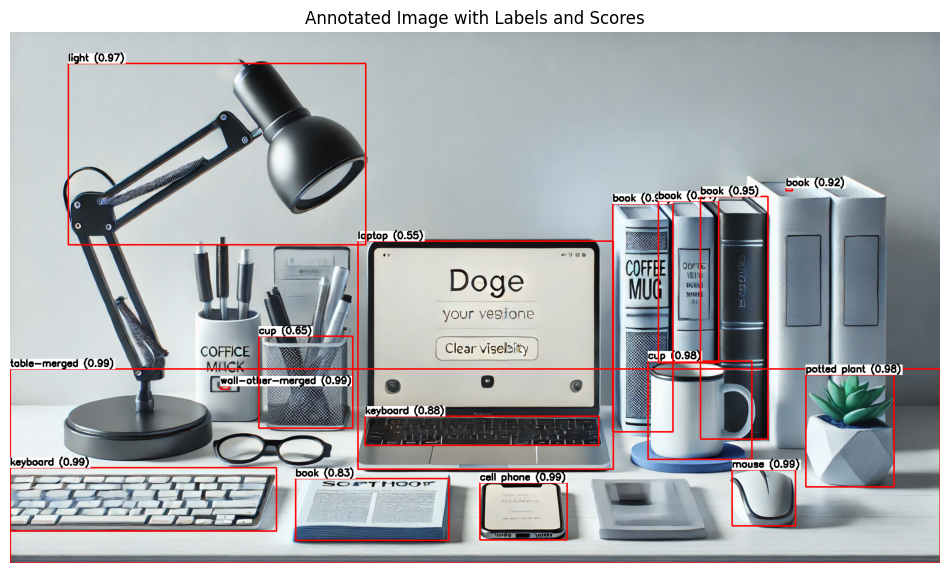

In [52]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Convert the segmentation map to a NumPy array
segmentation_map = result["segmentation"].cpu().numpy()

# Convert the NumPy array to an OpenCV image
segmentation_map_image = (segmentation_map * 255).astype("uint8")

# Convert the image to BGR (for OpenCV)
overlay_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

# Initialize the font and other settings
font_scale = 0.6  # Adjusted font scale for smaller text
font = cv2.FONT_HERSHEY_SIMPLEX
font_thickness = 2
font_color = (0, 0, 0)  # Black color for text

# Annotate the image with labels and scores
for segment in segments_info:
    label_id = segment["label_id"]
    label = id2label[label_id]
    score = segment["score"]

    # Find the bounding box of the segment
    mask = (segmentation_map == segment["id"]).astype("uint8")
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        x, y, w, h = cv2.boundingRect(contours[0])
        cv2.rectangle(overlay_image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red bounding box
        text = f"{label} ({score:.2f})"
        text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
        text_w, text_h = text_size
        cv2.rectangle(overlay_image, (x, y - text_h - 5), (x + text_w, y), (255, 255, 255), -1)  # White background for text
        cv2.putText(overlay_image, text, (x, y - 5), font, font_scale, font_color, font_thickness)

# Convert the image back to RGB for displaying in matplotlib
annotated_image = cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB)

# Display the result
plt.figure(figsize=(12, 8))
plt.imshow(annotated_image)
plt.title("Annotated Image with Labels and Scores")
plt.axis('off')
plt.show()


## Output Generation

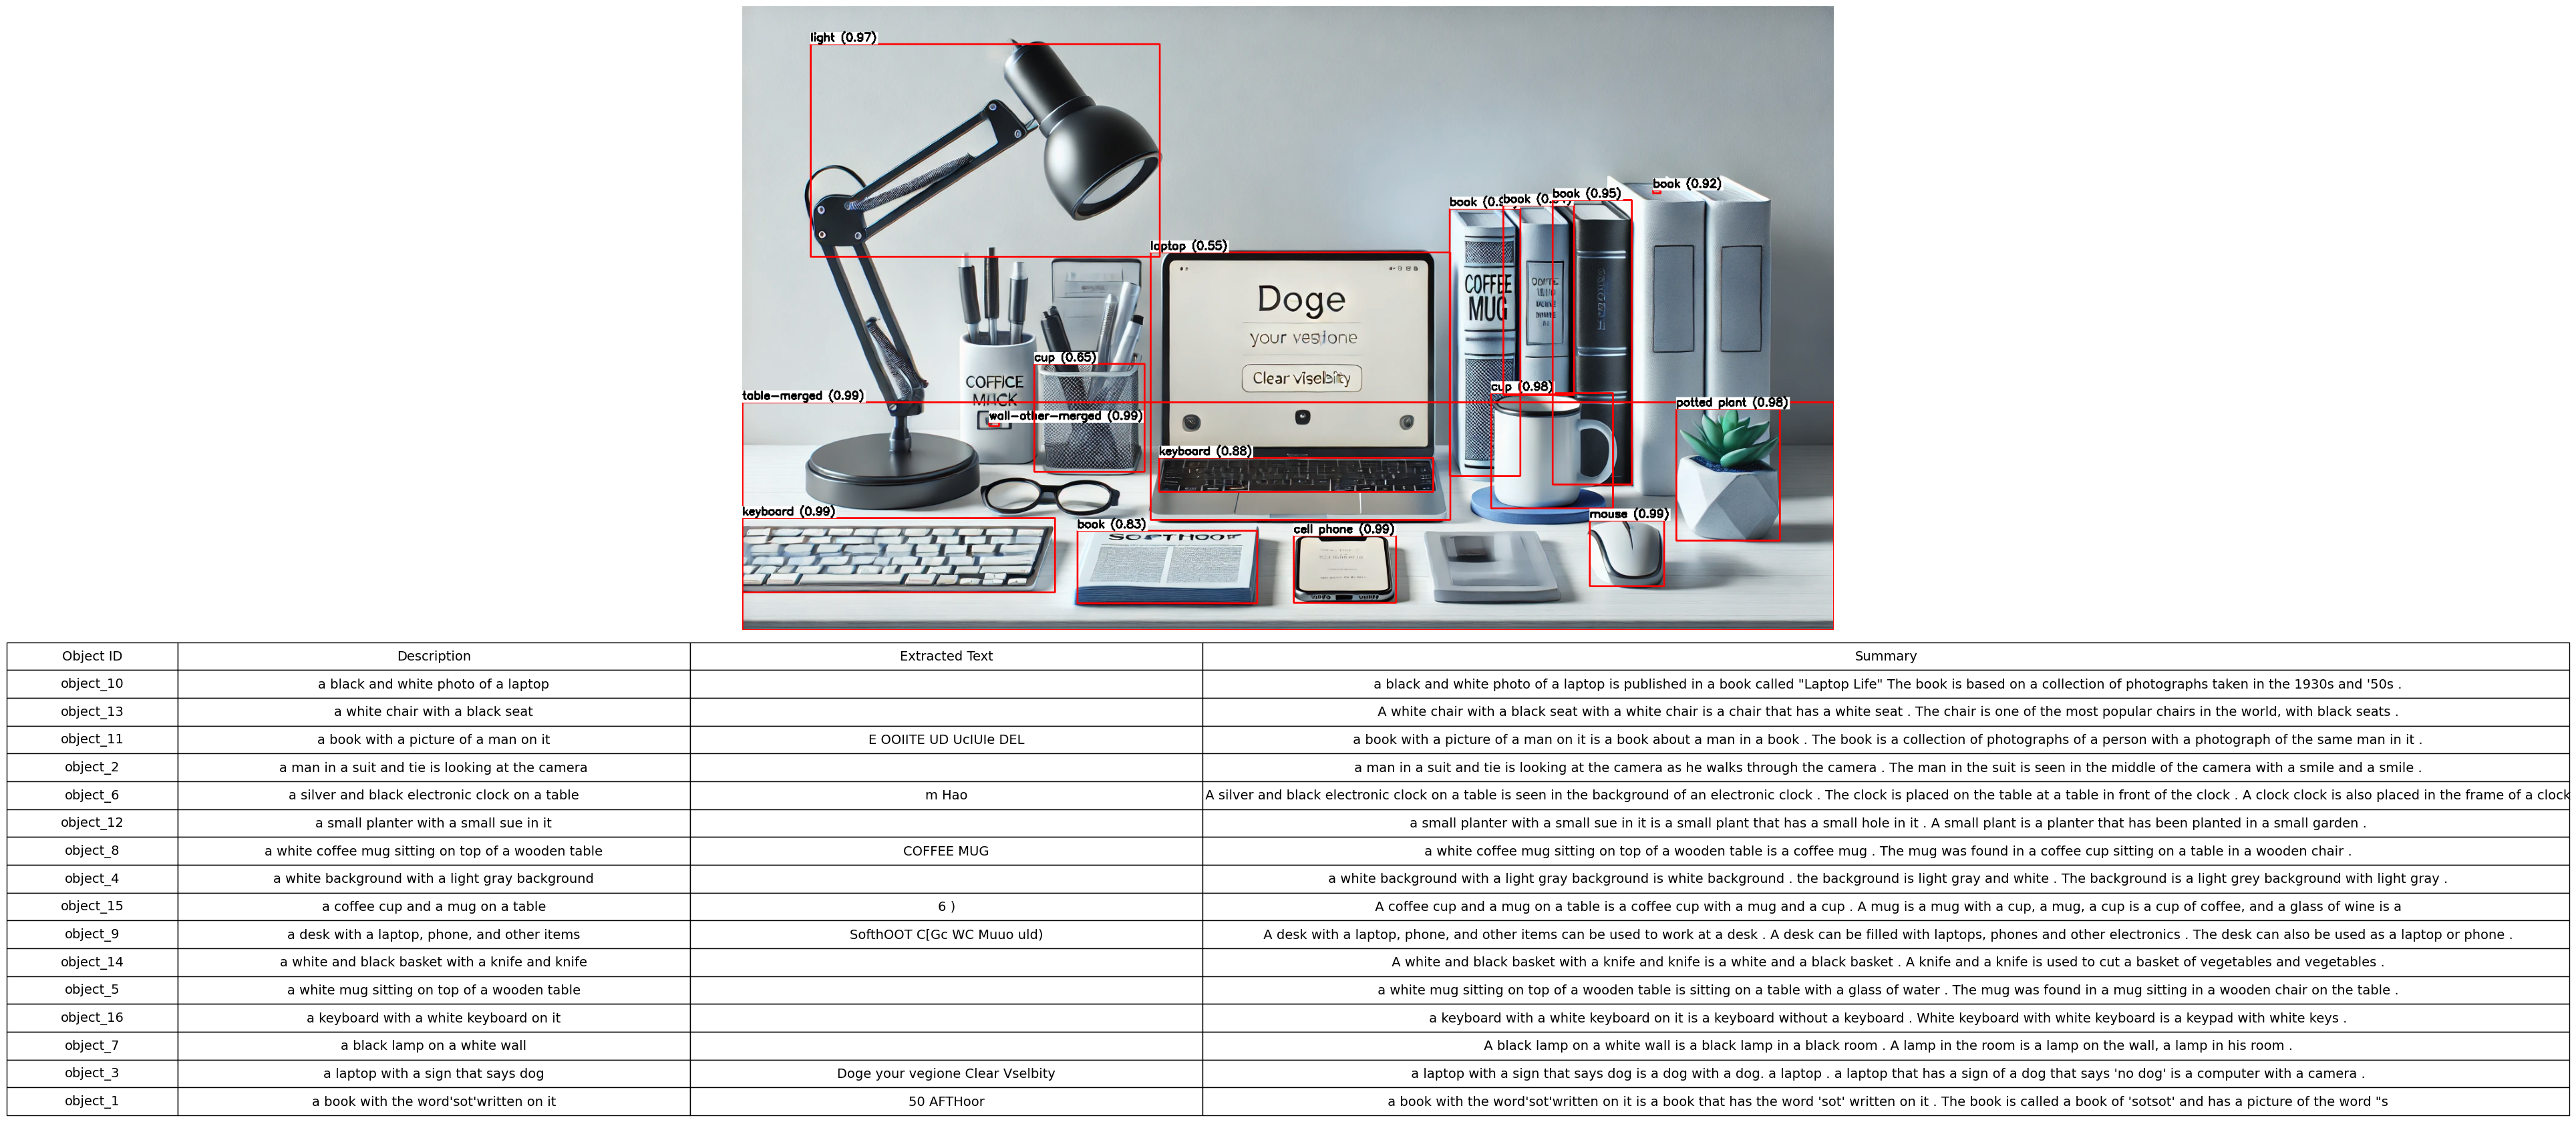

In [103]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Display the image and the table side by side
fig = plt.figure(figsize=(22, 20))  # Increase figure size if needed
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1.5])  # Increase height ratio for the image section

# Display the annotated image
ax0 = plt.subplot(gs[0])
ax0.imshow(annotated_image)
ax0.axis('off')  # Turn off axis

# Display the table using the existing DataFrame
ax1 = plt.subplot(gs[1])
ax1.axis('tight')
ax1.axis('off')

table = ax1.table(
    cellText=df.values,  # Use your existing DataFrame here
    colLabels=df.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.1, 0.3, 0.3, 0.8],  # Further adjust column widths
)

# Adjust font size to fit text
table.auto_set_font_size(False)
table.set_fontsize(14)  # Adjust font size to ensure all text fits

# Adjust the row height to ensure visibility
table.scale(1.5, 2.5)  # Further increase height scaling

plt.show()
